# DIOMIRA

Leaving there and proceeding for three days toward the east, you reach Diomira, a city with sixty silver domes, bronze statues of all the gods, streets paved with lead, a crystal theater, a golden cock that crows every morning on a tower. All these beauties will already be familiar to the visitor, who has seen them also in other cities. But the special quality of this city for the man who arrives there on a September evening, when the days are growing shorter and the multicolored lamps are lighted all at once at the doors of the food stalls and from a terrace a woman's voice cries ooh!, is that he feels envy toward those who now believe they have once before lived an evening identical to this and who think they were happy, that time.

In [1]:
from __future__ import print_function

In [2]:
from IPython.display import Image

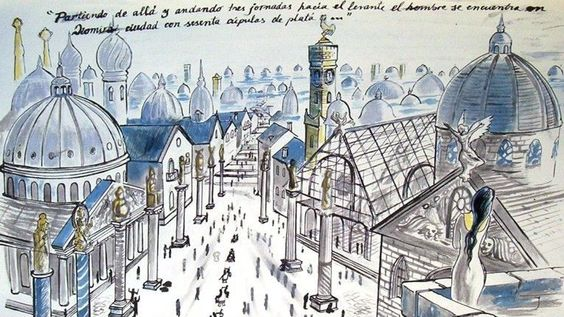

In [4]:
Image(filename='../../../Images/Diomira.jpg') 

### DIOMIRA
        1. Reads an MCRD file produced by art/centella, which stores MCRD waveforms for PMTs (bins of 1 ns)
        and the SiPMs (bins of 1 mus)
            

        2. Simulates the response of the energy plane in the PMTs MCRD, and produces both RWF and TWF:
        see:https://github.com/jjgomezcadenas/IC/blob/master/Notebooks/Cities/Nh5-Event-Model.ipynb
        
            
        3. Simulates the response of the tracking plane in the SiPMs MCRD and outputs
            SiPM RWF and TWF. The sipm RWF are ZS before storage to save space

        4. Add a table describing the FEE parameters used for simulation

        5. Copies the tables on geometry, detector data and MC

In [5]:
%matplotlib inline

In [6]:
%load_ext autoreload

In [7]:
%autoreload 2

In [8]:
import logging
import sys
logger = logging.getLogger()
#logger.handlers[0].stream = sys.stdout
logger.setLevel(logging.DEBUG)

In [9]:
from Util import *
from Configure import *
from Nh5 import *

In [10]:
import tables
from time import time 
import pandas as pd

In [11]:
import FEParam as FP
import SPE as SP
import FEE2 as FE

In [12]:
import mplFunctions as mpl
import wfmFunctions as wfm
import sensorFunctions as snf

In [13]:
import cProfile

In [14]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

In [15]:
import time

### Diomira NB revisited on:

In [16]:
print(time.strftime("%d/%m/%Y"))

14/10/2016


In [17]:
print(time.strftime("%H:%M:%S"))

05:29:58


#### ICDIR is a  environment variable pointing to the IC root directory (define in your profile)
#### ICDAT is a environment variable pointing to the IC root directory (define in your profile)

In [18]:
ic = %env ICDIR

In [19]:
ic

'/Users/jjgomezcadenas/Documents/Development/NEXT/IC'

### Script in IC/Cities/DIOMIRA.py

### Input file

In [26]:
# %load ../../../Cities/DIOMIRA.py
"""
DIOMIRA
JJGC August-October 2016
GML October 2016

What DIOMIRA does:
1) Reads a MCRD file containing MC waveforms for the 12 PMTs of the EP.
   Each waveform contains number of PEs in bins of 1 ns.
2) Convolves the PE waveform with the response of the FEE electronics.
3) Decimates the waveform, simulating the effect of the DAQ sampling (25 ns bins)
4) Writes a RWF file with the new data and adds the FEE simulation parameters as metadata
"""

from __future__ import print_function
from Util import *
from LogConfig import *
from Configure import *
from Nh5 import *
import FEParam as FP
import SPE as SP
import FEE2 as FE

import tables
from time import time
import wfmFunctions as wfm
import pandas as pd

from RandomSampling import NoiseSampler as SiPMsNoiseSampler
#------


"""

DIOMIRA
ChangeLog:

26.9

Changed types of PMTRWF, SIPMRWF and PMTTWF to Float32 for
    (compatibility with ART/GATE)

Do not store EPMT and ESIPM (can be computed on the fly)

Change sign of pmtrwf to negative (as produced by the DAQ)

28.9 add cython

29.9 changed the way true waveforms are treated.
before: --> full waveform (in bins of 25 ns) in an EArray
now--> ZS waveform rebinned at 1 mus in a Table
(adavantages:) faster processing less space

01.10 moved loop definition to Configure.py and added index to TWF table

11.10 introduced SiPM noise. SiPMs' true waveforms stored under TWF group.
Some variables, classes and functions renamed for clarity.

12.10 ZS functions to store the SiPMs

13.10 Reutilization of functions and some duplicities removed

"""
def FEE_param_table(fee_table):
    """
    Stores the parameters of the EP FEE simulation
    """
    row = fee_table.row
    row['offset'] = FP.offset
    row['pmt_gain'] = FP.PMT_GAIN
    row['V_gain'] = FP.V_GAIN
    row['R'] = FP.R
    row['C12'] = FP.C12
    row['AC'] = FP.AC
    row['time_step'] = FP.time_step
    row['time_daq'] = FP.time_DAQ
    row['freq_LPF'] = FP.freq_LPF
    row['freq_HPF'] = 1./(2*pi*FP.R*FP.C)
    row['LSB'] = FP.LSB
    row['volts_to_adc'] = FP.voltsToAdc/volt
    row['noise_fee_rms'] = FP.NOISE_FEE
    row['noise_adc'] = FP.NOISE_ADC

    row.append()

# def pmt_twf_signal(event_number,pmtrd, stride):
#     """
#     1) takes pmtrd
#     2) Performs ZS
#     3) Rebins resulting wf according to stride
#     """
#
#     rdata = {}
#
#     for j in range(pmtrd.shape[1]):
#         logger.debug("-->PMT number ={}".format(j))
#
#         energy_pes = pmtrd[event_number, j] #waveform for event event_number, PMT j
#         time_mus = np.arange(pmtrd.shape[2])*ns/mus
#
#         twf_zs = wfm.wf_thr(wfm.wf2df(time_mus,energy_pes),0.5)
#         time_mus, ene_pes = wfm.rebin_twf(twf_zs.time_mus.values,twf_zs.ene_pes.values,stride)
#         if not time_mus.any(): continue
#         twf = wfm.wf2df(time_mus, ene_pes)
#
#         logger.debug("-->len(twf) ={}".format(len(twf)))
#
#         rdata[j] = twf
#     return rdata

def simulate_sipm_response(event_number,sipmrd_,sipms_noise_sampler):
    """
    Add noise with the SiPMNoiseSampler class and return the noisy waveform.
    """
    return sipmrd_[event_number] + sipms_noise_sampler.Sample()


def simulate_pmt_response(event_number,pmtrd_):
    """
    Sensor Response
    Given a signal in PE (photoelectrons in bins of 1 ns) and the response function of
    for a single photoelectron (spe) and front-end electronics (fee)
    this function produces the PMT raw data (adc counts bins 25 ns)

    pmtrd_ dataset that holds the PMT PE data for each PMT
    pmtrd25 dataset to be created with adc counts, bins 25 ns
    after convoluting with electronics
    """

    rdata = []

    for j in range(pmtrd_.shape[1]):
        logger.debug("-->PMT number ={}".format(j))

        pmt = pmtrd_[event_number, j] #waveform for event event_number, PMT j

        fee = FE.FEE(C=FP.C12[j],R= FP.R, f=FP.freq_LPF, RG=FP.V_GAIN)
        spe = SP.SPE(pmt_gain=FP.PMT_GAIN,x_slope = 5*ns,x_flat = 1*ns)

        signal_PMT = spe.SpePulseFromVectorPE(pmt) #PMT response

        #Front end response to PMT pulse (in volts)
        signal_fee = fee.FEESignal(signal_PMT, noise_rms=FP.NOISE_FEE)

        #Signal out of DAQ
        #positive signal convention
        #signal_daq = fee.daqSignal(signal_fee, noise_rms=0) - FP.offset
        #negative signals convention!

        signal_daq = FP.offset -fee.daqSignal(signal_fee, noise_rms=0)

        rdata.append(signal_daq)
    return np.array(rdata)


def DIOMIRA(argv):
    """
    Diomira driver
    """
    DEBUG_LEVEL, INFO, CYTHON, CFP = configure(argv[0],argv[1:])

    if INFO:

        print("""
        DIOMIRA:
         1. Reads an MCRD file produced by art/centella, which stores MCRD
         waveforms for PMTs (bins of 1 ns)
        and the SiPMs (bins of 1 mus)


        2. Simulates the response of the energy plane in the PMTs MCRD,
        and produces both RWF and TWF:
        see: http://localhost:8931/notebooks/Nh5-Event-Model.ipynb#Reconstructed-Objects


        3. Simulates the response of the tracking plane in the SiPMs MCRD and outputs
            SiPM RWF (not yet implemented, for the time being simply copy the MCRD)

        4. Add a table describing the FEE parameters used for simulation

        5. Copies the tables on geometry, detector data and MC


        """)
        FP.print_FEE()

    PATH_IN =CFP['PATH_IN']
    PATH_OUT =CFP['PATH_OUT']
    FILE_IN =CFP['FILE_IN']
    FILE_OUT =CFP['FILE_OUT']
    PATH_DB =CFP['PATH_DB']
    FIRST_EVT =CFP['FIRST_EVT']
    LAST_EVT =CFP['LAST_EVT']
    RUN_ALL =CFP['RUN_ALL']
    CLIB =CFP['CLIB']
    CLEVEL =CFP['CLEVEL']
    # NOISE_CUT_FRACTION = CFP['NOISE_CUT_FRACTION']
    NEVENTS = LAST_EVT - FIRST_EVT

    logger.info('Debug level = {}'.format(DEBUG_LEVEL))

    logger.info("input path ={}; output path = {}; file_in ={} file_out ={}".format(
        PATH_IN,PATH_OUT,FILE_IN, FILE_OUT))

    logger.info("path to database = {}".format(PATH_DB))

    logger.info("first event = {} last event = {} nof events requested = {} ".format(
        FIRST_EVT,LAST_EVT,NEVENTS))

    logger.info("Compression library = {} Compression level = {} ".format(
        CLIB,CLEVEL))

    # logger.info("Noise cut fraction = {}".format(NOISE_CUT_FRACTION))
    # open the input file
    with tables.open_file("{}/{}".format(PATH_IN,FILE_IN), "r") as h5in:
        # access the PMT raw data in file

        pmtrd_  = h5in.root.pmtrd
        sipmrd_ = h5in.root.sipmrd

        #pmtrd_.shape = (nof_events, nof_sensors, wf_length)

        NPMT = pmtrd_.shape[1]
        NSIPM = sipmrd_.shape[1]
        PMTWL = pmtrd_.shape[2]
        #PMTWL_FEE = int((PMTWL+1)/FP.time_DAQ) #old format
        PMTWL_FEE = int(PMTWL/FP.time_DAQ)
        SIPMWL = sipmrd_.shape[2]
        NEVENTS_DST = pmtrd_.shape[0]

        logger.info("nof PMTs = {} nof  SiPMs = {} nof events in input DST = {} ".format(
        NPMT,NSIPM,NEVENTS_DST))

        logger.info("lof SiPM WF = {} lof PMT WF (MC) = {} lof PMT WF (FEE) = {}".format(
        PMTWL,SIPMWL,PMTWL_FEE))


        #access the geometry and the sensors metadata info

        geom_t = h5in.root.Detector.DetectorGeometry
        pmt_t = h5in.root.Sensors.DataPMT
        sipm_t = h5in.root.Sensors.DataSiPM
        mctrk_t = h5in.root.MC.MCTracks

        # Map of the SiPMs' sensorID to the index used by tables
        index_map = { sipm_t[i][0] : i for i in range(sipm_t.shape[0]) }

        # Create instance of the noise sampler and compute noise thresholds
        sipms_noise_sampler_ = SiPMsNoiseSampler(PATH_DB+"/NoiseSiPM_NEW.dat",index_map,SIPMWL,True)
        # sipms_noise_thresholds_ = sipms_noise_sampler_.ComputeThresholds(NOISE_CUT_FRACTION)

        # open the output file
        with tables.open_file("{}/{}".format(PATH_OUT,FILE_OUT), "w",
            filters=tables.Filters(complib=CLIB, complevel=CLEVEL)) as h5out:

            # create a group to store MC data
            mcgroup = h5out.create_group(h5out.root, "MC")
            # copy the mctrk table
            mctrk_t.copy(newparent=mcgroup)

            # create a group  to store geom data
            detgroup = h5out.create_group(h5out.root, "Detector")
            # copy the geom table
            geom_t.copy(newparent=detgroup)

            # create a group  store sensor data
            sgroup = h5out.create_group(h5out.root, "Sensors")
            # copy the pmt table
            pmt_t.copy(newparent=sgroup)
            # copy the sipm table
            sipm_t.copy(newparent=sgroup)

            # create a table to store Energy plane FEE data and hang it from MC group
            fee_table = h5out.create_table(mcgroup, "FEE", FEE,
                          "EP-FEE parameters",tables.Filters(0))


            # create a group to store True waveform data
            twfgroup = h5out.create_group(h5out.root, "TWF")

            # create a table to store true waveform (zs, rebinned)
            pmt_twf_table = h5out.create_table( twfgroup, "PMT", SENSOR_WF, "Store for PMTs TWF",
                                                tables.Filters(complib=CLIB, complevel=CLEVEL) )

            sipm_twf_table = h5out.create_table( twfgroup, "SiPM", SENSOR_WF, "Store for SiPMs TWF",
                                                 tables.Filters(complib=CLIB, complevel=CLEVEL) )

            #and index in event column
            pmt_twf_table.cols.event.create_index()
            sipm_twf_table.cols.event.create_index()

            # fill FEE table
            FEE_param_table(fee_table)

            # create a group to store RawData
            rgroup = h5out.create_group(h5out.root, "RD")

            # create an extensible array to store the RWF waveforms
            pmtrwf = h5out.create_earray(h5out.root.RD, "pmtrwf",
                                    atom=tables.Float32Atom(),
                                    shape=(0, NPMT, PMTWL_FEE),
                                    expectedrows=NEVENTS_DST)

            # sipm_rwf_table = h5out.create_table( rgroup, "sipmrwf", SENSOR_WF, "Store for SiPMs RWF",
            #                                      tables.Filters(complib=CLIB, complevel=CLEVEL) )

            sipmrwf = h5out.create_earray(h5out.root.RD, "sipmrwf",
                                    atom=tables.Float32Atom(),
                                    shape=(0, NSIPM, SIPMWL),
                                    expectedrows=NEVENTS_DST)
            #LOOP
            first_evt, last_evt = define_event_loop(FIRST_EVT,LAST_EVT,NEVENTS,NEVENTS_DST,RUN_ALL)

            t0 = time()
            for i in range(first_evt,last_evt):
                logger.info("-->event number ={}".format(i))

                # supress zeros in MCRD and rebins the ZS function in 1 mus bins

                rebin = int(1*mus/1*ns)  #rebins zs function in 1 mus bin

                #list with zs twf
                #truePMT  =  pmt_twf_signal(i,pmtrd_, rebin)
                # dict_map applies a function to the dictionary values
                truePMT  = dict_map( lambda df: wfm.rebin_df(df,rebin),
                                     wfm.sensor_wise_zero_suppresion(pmtrd_[i],0.,to_mus=ns/ms))
                trueSiPM = wfm.sensor_wise_zero_suppresion(sipmrd_[i],0.)

                #store in table
                wfm.store_wf(i, pmt_twf_table, truePMT)
                wfm.store_wf(i, sipm_twf_table, trueSiPM)

                #simulate PMT response and return an array with RWF
                #convert to float, append to EVector
                dataPMT = simulate_pmt_response(i,pmtrd_)
                print(dataPMT.dtype)
                dataPMT.astype(float)
                pmtrwf.append(dataPMT.reshape(1, NPMT, PMTWL_FEE))

                #simulate SiPM response and return an array with RWF
                #convert to float, zero suppress and dump to table
                dataSiPM = simulate_sipm_response(i,sipmrd_,sipms_noise_sampler_)
                print(dataSiPM.dtype)
                dataSiPM.astype(float)
                # zs_wfs = wfm.sensor_wise_zero_suppresion(dataSiPM,sipms_noise_thresholds_)
                # wfm.store_wf( i, sipm_rwf_table, zs_wfs )
                sipmrwf.append( dataSiPM.reshape(1,NSIPM,SIPMWL) )

            t1 = time()
            pmtrwf.flush()
            sipmrwf.flush()

            print("DIOMIRA has run over {} events in {} seconds".format(i, t1-t0))
    print("Leaving Diomira. Safe travels!")

#if __name__ == '__main__':
    #import cProfile

    #cProfile.run('DIOMIRA(sys.argv)', sort='time')
    #DIOMIRA(sys.argv)


In [59]:
ls -lh '/Users/jjgomezcadenas/Documents/Development/NEXT/data/test/nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_10000.root.h5'

-rw-r--r--  1 jjgomezcadenas  staff   336M Sep 29 21:49 /Users/jjgomezcadenas/Documents/Development/NEXT/data/test/nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_10000.root.h5


In [20]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/test/nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_10000.root.h5')

In [21]:
h5f

File(filename=/Users/jjgomezcadenas/Documents/Development/NEXT/data/test/nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_10000.root.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=0, shuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/pmtrd (EArray(1000, 12, 1200000), zlib(1)) ''
  atom := Float32Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 1, 32768)
/sipmrd (EArray(1000, 1789, 1200), zlib(1)) ''
  atom := Float32Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 50, 1200)
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
  description := {
  "x_det": Float32Col(shape=(2,), dflt=0.0, pos=0),
  "y_det": Float32Col(shape=(2,), dflt=0.0, pos=1),
  "z_det": Float32Col(shape=(2,), dflt=0.0, pos=2),
  "r_det": Float32Col(shape=(), dflt=0.0, pos=3)}
  byteorder := 'little'
  chunkshape := (2340,)
/MC (Group) ''
/MC/MCT

In [22]:
h5f.close()

### Configuration file

In [31]:
%less ../../../Config/DIOMIRA_NA_ZLIB_test.csv

#### Running the script

In [32]:
DIOMIRA(['DIOMIRA','-d','INFO','-c''../../../Config/DIOMIRA_NA_ZLIB_test.csv'])

INFO:root:Debug level = INFO


Debug level = INFO


INFO:root:input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/test/; output path = /Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_10000.root.h5 file_out =Kr_ACTIVE_5bar_float_1.h5


input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/test/; output path = /Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_10000.root.h5 file_out =Kr_ACTIVE_5bar_float_1.h5


INFO:root:path to database = /Users/jjgomezcadenas/Documents/Development/NEXT/IC/Database


path to database = /Users/jjgomezcadenas/Documents/Development/NEXT/IC/Database


INFO:root:first event = 0 last event = 1 nof events requested = 1 


first event = 0 last event = 1 nof events requested = 1 


INFO:root:Compression library = zlib Compression level = 1 


Compression library = zlib Compression level = 1 


INFO:root:nof PMTs = 12 nof  SiPMs = 1789 nof events in input DST = 1000 


nof PMTs = 12 nof  SiPMs = 1789 nof events in input DST = 1000 


INFO:root:lof SiPM WF = 1200000 lof PMT WF (MC) = 1200 lof PMT WF (FEE) = 48000


lof SiPM WF = 1200000 lof PMT WF (MC) = 1200 lof PMT WF (FEE) = 48000


Initializing NoiseSampler... OK
INFO:root:-->event number =0


-->event number =0


float64
float64
DIOMIRA has run over 0 events in 3.0914618969 seconds
Leaving Diomira. Safe travels!


### Checking the file

In [33]:
%ls -lh '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_ACTIVE_5bar_float_1.h5'

-rw-r--r--  1 jjgomezcadenas  staff   9.3M Oct 14 06:16 /Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_ACTIVE_5bar_float_1.h5


In [37]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_ACTIVE_5bar_float_1.h5')

In [38]:
h5f

File(filename=/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_ACTIVE_5bar_float_1.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=1, complib='zlib', shuffle=True, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
  description := {
  "x_det": Float32Col(shape=(2,), dflt=0.0, pos=0),
  "y_det": Float32Col(shape=(2,), dflt=0.0, pos=1),
  "z_det": Float32Col(shape=(2,), dflt=0.0, pos=2),
  "r_det": Float32Col(shape=(), dflt=0.0, pos=3)}
  byteorder := 'little'
  chunkshape := (2340,)
/MC (Group) ''
/MC/FEE (Table(1,)) 'EP-FEE parameters'
  description := {
  "offset": Int16Col(shape=(), dflt=0, pos=0),
  "pmt_gain": Float32Col(shape=(), dflt=0.0, pos=1),
  "V_gain": Float32Col(shape=(), dflt=0.0, pos=2),
  "R": Float32Col(shape=(), dflt=0.0, pos=3),
  "C12": Float32Col(shape=(12,), dflt=0.0, pos=4),
  "AC": Float32Col(shape=(12,), dflt=0.0, pos=5),
  "time_step": Float32C

In [39]:
h5f.close()

###  Running 10 events

In [40]:
DIOMIRA(['DIOMIRA','-d','INFO','-c''../../../Config/DIOMIRA_NA_ZLIB_test.csv'])

INFO:root:Debug level = INFO


Debug level = INFO


INFO:root:input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/test/; output path = /Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_10000.root.h5 file_out =Kr_ACTIVE_5bar_float_10.h5


input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/test/; output path = /Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_10000.root.h5 file_out =Kr_ACTIVE_5bar_float_10.h5


INFO:root:path to database = /Users/jjgomezcadenas/Documents/Development/NEXT/IC/Database


path to database = /Users/jjgomezcadenas/Documents/Development/NEXT/IC/Database


INFO:root:first event = 0 last event = 10 nof events requested = 10 


first event = 0 last event = 10 nof events requested = 10 


INFO:root:Compression library = zlib Compression level = 1 


Compression library = zlib Compression level = 1 


INFO:root:nof PMTs = 12 nof  SiPMs = 1789 nof events in input DST = 1000 


nof PMTs = 12 nof  SiPMs = 1789 nof events in input DST = 1000 


INFO:root:lof SiPM WF = 1200000 lof PMT WF (MC) = 1200 lof PMT WF (FEE) = 48000


lof SiPM WF = 1200000 lof PMT WF (MC) = 1200 lof PMT WF (FEE) = 48000


Initializing NoiseSampler... OK
INFO:root:-->event number =0


-->event number =0


float64
float64
INFO:root:-->event number =1


-->event number =1


float64
float64
INFO:root:-->event number =2


-->event number =2


float64
float64
INFO:root:-->event number =3


-->event number =3


float64
float64
INFO:root:-->event number =4


-->event number =4


float64
float64
INFO:root:-->event number =5


-->event number =5


float64
float64
INFO:root:-->event number =6


-->event number =6


float64
float64
INFO:root:-->event number =7


-->event number =7


float64
float64
INFO:root:-->event number =8


-->event number =8


float64
float64
INFO:root:-->event number =9


-->event number =9


float64
float64
DIOMIRA has run over 9 events in 31.6061961651 seconds
Leaving Diomira. Safe travels!


In [41]:
%ls -lh '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_ACTIVE_5bar_float_10.h5'

-rw-r--r--  1 jjgomezcadenas  staff    82M Oct 14 06:21 /Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_ACTIVE_5bar_float_10.h5


#### about 8 Mb per event

### Integer arrays (pmtrwf and sipmrwf)

In [58]:
class SENSOR_WF(tables.IsDescription):
    """
    Describes a true waveform (zero supressed)
    """
    event = tables.UInt32Col(pos=0)
    ID = tables.UInt32Col(pos=1)
    time_mus = tables.Float32Col(pos=2)
    ene_pes = tables.Int32Col(pos=3)

In [42]:
"""
DIOMIRA
JJGC August-October 2016
GML October 2016

What DIOMIRA does:
1) Reads a MCRD file containing MC waveforms for the 12 PMTs of the EP.
   Each waveform contains number of PEs in bins of 1 ns.
2) Convolves the PE waveform with the response of the FEE electronics.
3) Decimates the waveform, simulating the effect of the DAQ sampling (25 ns bins)
4) Writes a RWF file with the new data and adds the FEE simulation parameters as metadata
"""

from __future__ import print_function
from Util import *
from LogConfig import *
from Configure import *
from Nh5 import *
import FEParam as FP
import SPE as SP
import FEE2 as FE

import tables
from time import time
import wfmFunctions as wfm
import pandas as pd

from RandomSampling import NoiseSampler as SiPMsNoiseSampler
#------


"""

DIOMIRA
ChangeLog:

26.9

Changed types of PMTRWF, SIPMRWF and PMTTWF to Float32 for
    (compatibility with ART/GATE)

Do not store EPMT and ESIPM (can be computed on the fly)

Change sign of pmtrwf to negative (as produced by the DAQ)

28.9 add cython

29.9 changed the way true waveforms are treated.
before: --> full waveform (in bins of 25 ns) in an EArray
now--> ZS waveform rebinned at 1 mus in a Table
(adavantages:) faster processing less space

01.10 moved loop definition to Configure.py and added index to TWF table

11.10 introduced SiPM noise. SiPMs' true waveforms stored under TWF group.
Some variables, classes and functions renamed for clarity.

12.10 ZS functions to store the SiPMs

13.10 Reutilization of functions and some duplicities removed

"""
def FEE_param_table(fee_table):
    """
    Stores the parameters of the EP FEE simulation
    """
    row = fee_table.row
    row['offset'] = FP.offset
    row['pmt_gain'] = FP.PMT_GAIN
    row['V_gain'] = FP.V_GAIN
    row['R'] = FP.R
    row['C12'] = FP.C12
    row['AC'] = FP.AC
    row['time_step'] = FP.time_step
    row['time_daq'] = FP.time_DAQ
    row['freq_LPF'] = FP.freq_LPF
    row['freq_HPF'] = 1./(2*pi*FP.R*FP.C)
    row['LSB'] = FP.LSB
    row['volts_to_adc'] = FP.voltsToAdc/volt
    row['noise_fee_rms'] = FP.NOISE_FEE
    row['noise_adc'] = FP.NOISE_ADC

    row.append()

# def pmt_twf_signal(event_number,pmtrd, stride):
#     """
#     1) takes pmtrd
#     2) Performs ZS
#     3) Rebins resulting wf according to stride
#     """
#
#     rdata = {}
#
#     for j in range(pmtrd.shape[1]):
#         logger.debug("-->PMT number ={}".format(j))
#
#         energy_pes = pmtrd[event_number, j] #waveform for event event_number, PMT j
#         time_mus = np.arange(pmtrd.shape[2])*ns/mus
#
#         twf_zs = wfm.wf_thr(wfm.wf2df(time_mus,energy_pes),0.5)
#         time_mus, ene_pes = wfm.rebin_twf(twf_zs.time_mus.values,twf_zs.ene_pes.values,stride)
#         if not time_mus.any(): continue
#         twf = wfm.wf2df(time_mus, ene_pes)
#
#         logger.debug("-->len(twf) ={}".format(len(twf)))
#
#         rdata[j] = twf
#     return rdata

def simulate_sipm_response(event_number,sipmrd_,sipms_noise_sampler):
    """
    Add noise with the SiPMNoiseSampler class and return the noisy waveform.
    """
    return sipmrd_[event_number] + sipms_noise_sampler.Sample()


def simulate_pmt_response(event_number,pmtrd_):
    """
    Sensor Response
    Given a signal in PE (photoelectrons in bins of 1 ns) and the response function of
    for a single photoelectron (spe) and front-end electronics (fee)
    this function produces the PMT raw data (adc counts bins 25 ns)

    pmtrd_ dataset that holds the PMT PE data for each PMT
    pmtrd25 dataset to be created with adc counts, bins 25 ns
    after convoluting with electronics
    """

    rdata = []

    for j in range(pmtrd_.shape[1]):
        logger.debug("-->PMT number ={}".format(j))

        pmt = pmtrd_[event_number, j] #waveform for event event_number, PMT j

        fee = FE.FEE(C=FP.C12[j],R= FP.R, f=FP.freq_LPF, RG=FP.V_GAIN)
        spe = SP.SPE(pmt_gain=FP.PMT_GAIN,x_slope = 5*ns,x_flat = 1*ns)

        signal_PMT = spe.SpePulseFromVectorPE(pmt) #PMT response

        #Front end response to PMT pulse (in volts)
        signal_fee = fee.FEESignal(signal_PMT, noise_rms=FP.NOISE_FEE)

        #Signal out of DAQ
        #positive signal convention
        #signal_daq = fee.daqSignal(signal_fee, noise_rms=0) - FP.offset
        #negative signals convention!

        signal_daq = FP.offset -fee.daqSignal(signal_fee, noise_rms=0)

        rdata.append(signal_daq)
    return np.array(rdata)


def DIOMIRA(argv):
    """
    Diomira driver
    """
    DEBUG_LEVEL, INFO, CYTHON, CFP = configure(argv[0],argv[1:])

    if INFO:

        print("""
        DIOMIRA:
         1. Reads an MCRD file produced by art/centella, which stores MCRD
         waveforms for PMTs (bins of 1 ns)
        and the SiPMs (bins of 1 mus)


        2. Simulates the response of the energy plane in the PMTs MCRD,
        and produces both RWF and TWF:
        see: http://localhost:8931/notebooks/Nh5-Event-Model.ipynb#Reconstructed-Objects


        3. Simulates the response of the tracking plane in the SiPMs MCRD and outputs
            SiPM RWF (not yet implemented, for the time being simply copy the MCRD)

        4. Add a table describing the FEE parameters used for simulation

        5. Copies the tables on geometry, detector data and MC


        """)
        FP.print_FEE()

    PATH_IN =CFP['PATH_IN']
    PATH_OUT =CFP['PATH_OUT']
    FILE_IN =CFP['FILE_IN']
    FILE_OUT =CFP['FILE_OUT']
    PATH_DB =CFP['PATH_DB']
    FIRST_EVT =CFP['FIRST_EVT']
    LAST_EVT =CFP['LAST_EVT']
    RUN_ALL =CFP['RUN_ALL']
    CLIB =CFP['CLIB']
    CLEVEL =CFP['CLEVEL']
    # NOISE_CUT_FRACTION = CFP['NOISE_CUT_FRACTION']
    NEVENTS = LAST_EVT - FIRST_EVT

    logger.info('Debug level = {}'.format(DEBUG_LEVEL))

    logger.info("input path ={}; output path = {}; file_in ={} file_out ={}".format(
        PATH_IN,PATH_OUT,FILE_IN, FILE_OUT))

    logger.info("path to database = {}".format(PATH_DB))

    logger.info("first event = {} last event = {} nof events requested = {} ".format(
        FIRST_EVT,LAST_EVT,NEVENTS))

    logger.info("Compression library = {} Compression level = {} ".format(
        CLIB,CLEVEL))

    # logger.info("Noise cut fraction = {}".format(NOISE_CUT_FRACTION))
    # open the input file
    with tables.open_file("{}/{}".format(PATH_IN,FILE_IN), "r") as h5in:
        # access the PMT raw data in file

        pmtrd_  = h5in.root.pmtrd
        sipmrd_ = h5in.root.sipmrd

        #pmtrd_.shape = (nof_events, nof_sensors, wf_length)

        NPMT = pmtrd_.shape[1]
        NSIPM = sipmrd_.shape[1]
        PMTWL = pmtrd_.shape[2]
        #PMTWL_FEE = int((PMTWL+1)/FP.time_DAQ) #old format
        PMTWL_FEE = int(PMTWL/FP.time_DAQ)
        SIPMWL = sipmrd_.shape[2]
        NEVENTS_DST = pmtrd_.shape[0]

        logger.info("nof PMTs = {} nof  SiPMs = {} nof events in input DST = {} ".format(
        NPMT,NSIPM,NEVENTS_DST))

        logger.info("lof SiPM WF = {} lof PMT WF (MC) = {} lof PMT WF (FEE) = {}".format(
        PMTWL,SIPMWL,PMTWL_FEE))


        #access the geometry and the sensors metadata info

        geom_t = h5in.root.Detector.DetectorGeometry
        pmt_t = h5in.root.Sensors.DataPMT
        sipm_t = h5in.root.Sensors.DataSiPM
        mctrk_t = h5in.root.MC.MCTracks

        # Map of the SiPMs' sensorID to the index used by tables
        index_map = { sipm_t[i][0] : i for i in range(sipm_t.shape[0]) }

        # Create instance of the noise sampler and compute noise thresholds
        sipms_noise_sampler_ = SiPMsNoiseSampler(PATH_DB+"/NoiseSiPM_NEW.dat",index_map,SIPMWL,True)
        # sipms_noise_thresholds_ = sipms_noise_sampler_.ComputeThresholds(NOISE_CUT_FRACTION)

        # open the output file
        with tables.open_file("{}/{}".format(PATH_OUT,FILE_OUT), "w",
            filters=tables.Filters(complib=CLIB, complevel=CLEVEL)) as h5out:

            # create a group to store MC data
            #mcgroup = h5out.create_group(h5out.root, "MC")
            # copy the mctrk table
            #mctrk_t.copy(newparent=mcgroup)

            # create a group  to store geom data
            detgroup = h5out.create_group(h5out.root, "Detector")
            # copy the geom table
            geom_t.copy(newparent=detgroup)

            # create a group  store sensor data
            sgroup = h5out.create_group(h5out.root, "Sensors")
            # copy the pmt table
            pmt_t.copy(newparent=sgroup)
            # copy the sipm table
            sipm_t.copy(newparent=sgroup)

            # create a table to store Energy plane FEE data and hang it from MC group
            fee_table = h5out.create_table(mcgroup, "FEE", FEE,
                          "EP-FEE parameters",tables.Filters(0))


            # create a group to store True waveform data
            twfgroup = h5out.create_group(h5out.root, "TWF")

            # create a table to store true waveform (zs, rebinned)
            pmt_twf_table = h5out.create_table( twfgroup, "PMT", SENSOR_WF, "Store for PMTs TWF",
                                                tables.Filters(complib=CLIB, complevel=CLEVEL) )

            sipm_twf_table = h5out.create_table( twfgroup, "SiPM", SENSOR_WF, "Store for SiPMs TWF",
                                                 tables.Filters(complib=CLIB, complevel=CLEVEL) )

            #and index in event column
            pmt_twf_table.cols.event.create_index()
            sipm_twf_table.cols.event.create_index()

            # fill FEE table
            FEE_param_table(fee_table)

            # create a group to store RawData
            rgroup = h5out.create_group(h5out.root, "RD")

            # create an extensible array to store the RWF waveforms
            pmtrwf = h5out.create_earray(h5out.root.RD, "pmtrwf",
                                    atom=tables.Int32Atom(),
                                    shape=(0, NPMT, PMTWL_FEE),
                                    expectedrows=NEVENTS_DST)

            # sipm_rwf_table = h5out.create_table( rgroup, "sipmrwf", SENSOR_WF, "Store for SiPMs RWF",
            #                                      tables.Filters(complib=CLIB, complevel=CLEVEL) )

            sipmrwf = h5out.create_earray(h5out.root.RD, "sipmrwf",
                                    atom=tables.Int32Atom(),
                                    shape=(0, NSIPM, SIPMWL),
                                    expectedrows=NEVENTS_DST)
            #LOOP
            first_evt, last_evt = define_event_loop(FIRST_EVT,LAST_EVT,NEVENTS,NEVENTS_DST,RUN_ALL)

            t0 = time()
            for i in range(first_evt,last_evt):
                logger.info("-->event number ={}".format(i))

                # supress zeros in MCRD and rebins the ZS function in 1 mus bins

                rebin = int(1*mus/1*ns)  #rebins zs function in 1 mus bin

                #list with zs twf
                #truePMT  =  pmt_twf_signal(i,pmtrd_, rebin)
                # dict_map applies a function to the dictionary values
                truePMT  = dict_map( lambda df: wfm.rebin_df(df,rebin),
                                     wfm.sensor_wise_zero_suppresion(pmtrd_[i],0.,to_mus=ns/ms))
                trueSiPM = wfm.sensor_wise_zero_suppresion(sipmrd_[i],0.)

                #store in table
                wfm.store_wf(i, pmt_twf_table, truePMT)
                wfm.store_wf(i, sipm_twf_table, trueSiPM)

                #simulate PMT response and return an array with RWF
                #convert to float, append to EVector
                dataPMT = simulate_pmt_response(i,pmtrd_)
                print(dataPMT.dtype)
                dataPMT.astype(int)
                pmtrwf.append(dataPMT.reshape(1, NPMT, PMTWL_FEE))

                #simulate SiPM response and return an array with RWF
                #convert to float, zero suppress and dump to table
                dataSiPM = simulate_sipm_response(i,sipmrd_,sipms_noise_sampler_)
                print(dataSiPM.dtype)
                dataSiPM.astype(int)
                # zs_wfs = wfm.sensor_wise_zero_suppresion(dataSiPM,sipms_noise_thresholds_)
                # wfm.store_wf( i, sipm_rwf_table, zs_wfs )
                sipmrwf.append( dataSiPM.reshape(1,NSIPM,SIPMWL) )

            t1 = time()
            pmtrwf.flush()
            sipmrwf.flush()

            print("DIOMIRA has run over {} events in {} seconds".format(i, t1-t0))
    print("Leaving Diomira. Safe travels!")

#if __name__ == '__main__':
    #import cProfile

    #cProfile.run('DIOMIRA(sys.argv)', sort='time')
    #DIOMIRA(sys.argv)



In [43]:
DIOMIRA(['DIOMIRA','-d','INFO','-c''../../../Config/DIOMIRA_NA_ZLIB_test.csv'])

INFO:root:Debug level = INFO


Debug level = INFO


INFO:root:input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/test/; output path = /Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_10000.root.h5 file_out =Kr_ACTIVE_5bar_int_10.h5


input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/test/; output path = /Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_10000.root.h5 file_out =Kr_ACTIVE_5bar_int_10.h5


INFO:root:path to database = /Users/jjgomezcadenas/Documents/Development/NEXT/IC/Database


path to database = /Users/jjgomezcadenas/Documents/Development/NEXT/IC/Database


INFO:root:first event = 0 last event = 10 nof events requested = 10 


first event = 0 last event = 10 nof events requested = 10 


INFO:root:Compression library = zlib Compression level = 1 


Compression library = zlib Compression level = 1 


INFO:root:nof PMTs = 12 nof  SiPMs = 1789 nof events in input DST = 1000 


nof PMTs = 12 nof  SiPMs = 1789 nof events in input DST = 1000 


INFO:root:lof SiPM WF = 1200000 lof PMT WF (MC) = 1200 lof PMT WF (FEE) = 48000


lof SiPM WF = 1200000 lof PMT WF (MC) = 1200 lof PMT WF (FEE) = 48000


Initializing NoiseSampler... OK
INFO:root:-->event number =0


-->event number =0


float64
float64
INFO:root:-->event number =1


-->event number =1


float64
float64
INFO:root:-->event number =2


-->event number =2


float64
float64
INFO:root:-->event number =3


-->event number =3


float64
float64
INFO:root:-->event number =4


-->event number =4


float64
float64
INFO:root:-->event number =5


-->event number =5


float64
float64
INFO:root:-->event number =6


-->event number =6


float64
float64
INFO:root:-->event number =7


-->event number =7


float64
float64
INFO:root:-->event number =8


-->event number =8


float64
float64
INFO:root:-->event number =9


-->event number =9


float64
float64
DIOMIRA has run over 9 events in 27.117399931 seconds
Leaving Diomira. Safe travels!


In [44]:
%ls -lh '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_ACTIVE_5bar_int_10.h5'

-rw-r--r--  1 jjgomezcadenas  staff   3.9M Oct 14 06:27 /Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_ACTIVE_5bar_int_10.h5


#### BINGO!!!! 390 kb per event!

In [45]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_ACTIVE_5bar_int_10.h5')

In [47]:
h5f

File(filename=/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_ACTIVE_5bar_int_10.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=1, complib='zlib', shuffle=True, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
  description := {
  "x_det": Float32Col(shape=(2,), dflt=0.0, pos=0),
  "y_det": Float32Col(shape=(2,), dflt=0.0, pos=1),
  "z_det": Float32Col(shape=(2,), dflt=0.0, pos=2),
  "r_det": Float32Col(shape=(), dflt=0.0, pos=3)}
  byteorder := 'little'
  chunkshape := (2340,)
/MC (Group) ''
/MC/FEE (Table(1,)) 'EP-FEE parameters'
  description := {
  "offset": Int16Col(shape=(), dflt=0, pos=0),
  "pmt_gain": Float32Col(shape=(), dflt=0.0, pos=1),
  "V_gain": Float32Col(shape=(), dflt=0.0, pos=2),
  "R": Float32Col(shape=(), dflt=0.0, pos=3),
  "C12": Float32Col(shape=(12,), dflt=0.0, pos=4),
  "AC": Float32Col(shape=(12,), dflt=0.0, pos=5),
  "time_step": Float32Co

### Checking PMTRWF data

In [48]:
def get_vectors(h5f):
    """
    input: file pointer
    returns: data vectors
    """
    pmtrwf = h5f.root.RD.pmtrwf
    sipmrwf = h5f.root.RD.sipmrwf
    geom_t = h5f.root.Detector.DetectorGeometry
    pmt_t = h5f.root.Sensors.DataPMT
    sipm_t = h5f.root.Sensors.DataSiPM
    gdf = snf.read_data_geom(geom_t)
    pmtdf = snf.read_data_sensors(pmt_t)
    sipmdf = snf.read_data_sensors(sipm_t)
    return pmtrwf,sipmrwf,pmtdf,sipmdf,gdf

In [49]:
pmtrwf,sipmrwf,pmtdf,sipmdf,gdf = get_vectors(h5f)

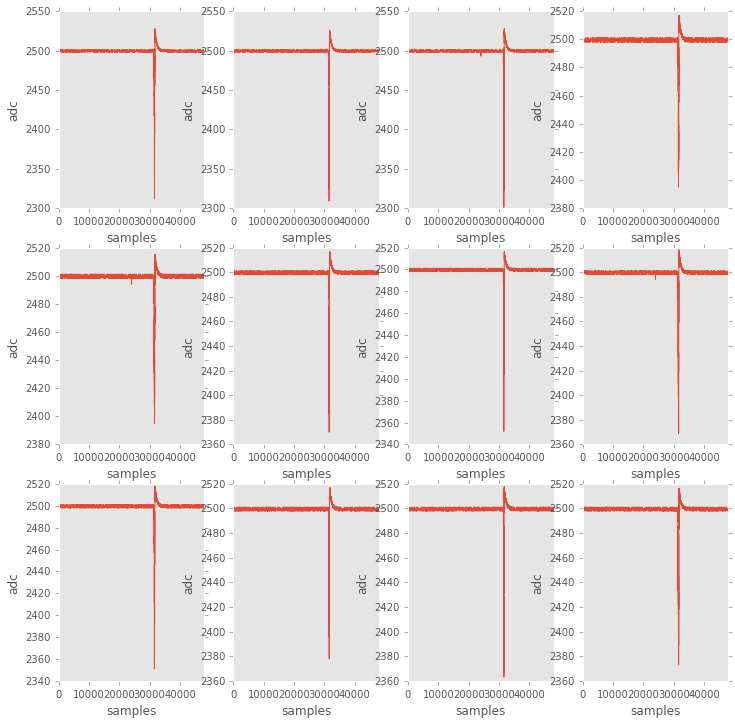

Press a key...


In [50]:
mpl.scan_waveforms(pmtrwf,list_of_events=[0])

In [51]:
pmtr0 = pmtrwf[0,0]

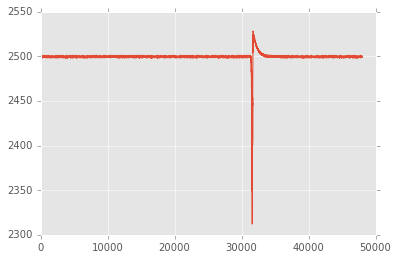

In [52]:
plt.plot(pmtr0)

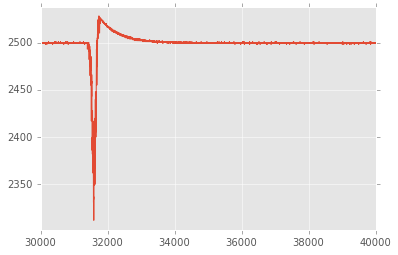

In [53]:
mpl.plts(pmtr0, signal_start=30000, signal_end=40000, offset=10)

In [54]:
sgn = 4096 - pmtr0

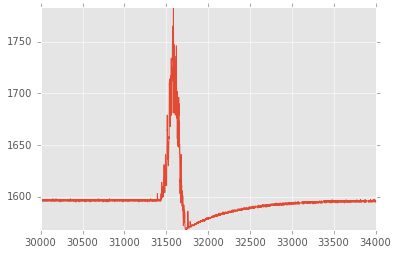

In [55]:
mpl.plts(sgn, signal_start=30000, signal_end=34000, offset=0)

### Reading the table of true waveforms

In [56]:
pmttwf = h5f.root.TWF.PMT

In [57]:
pmttwf

/TWF/PMT (Table(120,), shuffle, zlib(1)) 'Store for PMTs TWF'
  description := {
  "event": UInt32Col(shape=(), dflt=0, pos=0),
  "ID": UInt32Col(shape=(), dflt=0, pos=1),
  "time_mus": Float32Col(shape=(), dflt=0.0, pos=2),
  "ene_pes": Float32Col(shape=(), dflt=0.0, pos=3)}
  byteorder := 'little'
  chunkshape := (4096,)
  autoindex := True
  colindexes := {
    "event": Index(6, medium, shuffle, zlib(1)).is_csi=False}

In [42]:
pmt_list =range(pmtrwf.shape[1])
print(pmt_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


In [45]:
pmtp = wfm.read_twf(pmttwf, pmt_list, event_number=1)

works! We can access the data frames of the panel

In [47]:
pmtp[11]

,ene_pes,time_mus
0,759.0,885.289612


In [48]:
pmtp.items

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], dtype='int64')

In [50]:
pmtp[1]

,ene_pes,time_mus
0,967.0,885.499939


In [52]:
pmtp[1].sum().ene_pes

967.0

In [53]:
def true_energy(sensorp):
    return sum(sensorp[i].ene_pes.values.sum() for i in sensorp.items)
    

In [54]:
def true_energy_distribution(pmttwf,pmt_list,event_list=range(10)):
    return np.array([true_energy(wfm.read_twf(pmttwf, pmt_list, event_number=event)) for event in event_list])
        

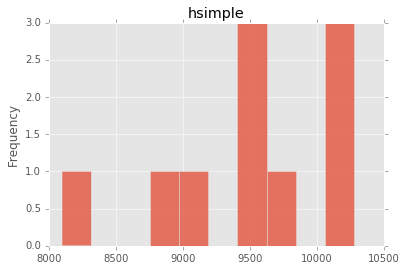

In [56]:
x = true_energy_distribution(pmttwf,pmt_list,event_list=range(10))
mpl.histo(x,10)

### Plot true and reco wfm

In [57]:
sipmdf.index

RangeIndex(start=0, stop=1789, step=1)

In [ ]:
sipmrwfp = wfm.read_twf(sipmrwf, pmt_list, event_number=1)

In [ ]:
def plot_best(sipmrwf,sipmtwf,sipmdf, evt = 0):
    '''
        Plot the noisy waveform of the SiPM with greatest charge and superimpose the true waveform.
    '''
    #Find SiPM with greatest peak
    maxsipm = np.unravel_index(sipmrwf[evt,:,:].argmax(),sipmrwf[evt,:,:].shape)[0]
    print("SiPM with greatest peak is at index {} with ID {}".format(maxsipm,sipmdf.ix[maxsipm].channel))
    # Plot noisy waveform in red and noiseless waveform in blue
    true_times, true_amps = zip(*[ (row['time_mus'],row['ene_pes']) for row in sipmtwfm.iterrows() if row['event'] == evt and row['sipm'] == maxsipm ])
    plt.plot(sipmrwf[evt,maxsipm,:])
    plt.plot(true_times,true_amps)

In [64]:
pmtp = read_sensor_twf(pmttwf, pmt_list, event_number=9)

In [65]:
pmtp

<class 'pandas.core.panel.Panel'>
Dimensions: 12 (items) x 1 (major_axis) x 2 (minor_axis)
Items axis: 0 to 11
Major_axis axis: 0 to 0
Minor_axis axis: ene_pes to time_mus

In [66]:
pmtp[1]

,ene_pes,time_mus
0,942.0,1063.665283


But what i

In [ ]:
PMT={ ipmt : wfm.wf2df(zip(*[ (row['time_mus'],row['ene_pes']) for row in pmttwfm.iterrows() if row['event']== event_number and row['pmt']== ipmt])) for ipmt in pmt_list }
#
for ipmt in pmt_list:
    time_mus, ene_pes = zip(*[ (row['time_mus'],row['ene_pes']) for row in pmttwfm.iterrows() if row['event']== event_number and row['pmt']== ipmt])
                             
    PMT[i] = wfm.wf2df(time_mus,energy_pes)
                             
                        

In [40]:
import sensorFunctions as snf

In [41]:
def get_vectors(h5f):
    """
    input: file pointer
    returns: data vectors
    """
    pmtrwf = h5f.root.RD.pmtrwf
    sipmrwf = h5f.root.RD.sipmrwf
    geom_t = h5f.root.Detector.DetectorGeometry
    pmt_t = h5f.root.Sensors.DataPMT
    sipm_t = h5f.root.Sensors.DataSiPM
    gdf = snf.read_data_geom(geom_t)
    pmtdf = snf.read_data_sensors(pmt_t)
    sipmdf = snf.read_data_sensors(sipm_t)
    return pmtrwf,sipmrwf,pmtdf,sipmdf,gdf


In [43]:
pmtrwf,sipmrwf,pmtdf,sipmdf,gdf = get_vectors(h5f)

In [44]:
pmtdf

,active,adc_to_pes,channel,gain,x,y
0,1,-22.916800,0,0.001641,-23.941401,65.778503
1,1,-23.750999,1,0.001623,-44.995098,-53.623100
2,1,-25.300800,2,0.000000,68.936501,-12.155400
3,1,-25.998400,3,0.000000,-0.000000,185.000000
4,1,-23.707399,4,0.001596,-118.916000,141.718002
5,1,-20.892700,5,0.001581,-182.188995,32.124901
6,1,-22.134001,6,0.000000,-160.214996,-92.500000
7,1,-33.099300,7,0.000000,-63.273701,-173.843002
8,1,-20.437700,8,0.001622,63.273701,-173.843002
9,1,-25.169800,9,0.001601,160.214996,-92.500000


In [ ]:
plot_pmtwf(PMTWF)

In [80]:
sipmr = sipmrwf[0]

In [109]:
def ene_sipm(sipmrwf, event_list=[0]):
    SIPM =[]
    for event in event_list:
        sipmrw = sipmrwf[event]
        ESIPM = []
        for i in range(sipmrwf.shape[1]):
            sipmw = sipmrw[i]
            xsum = np.sum(sipmw)
            if xsum > 0:
                ESIPM.append(xsum)
        SIPM.append(np.max(np.array(ESIPM)))
    return SIPM
                    

In [114]:
esipm = ene_sipm(sipmrwf, event_list=range(1000))

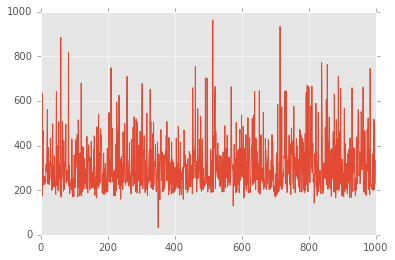

In [115]:
plt.plot(esipm)

In [116]:
np.average(esipm)

310.12219